In [1]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [2]:
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset_original = datasets.MNIST(
    './data',
    train = True,
    download = True,
    transform = transform
)

test_dataset_original = datasets.MNIST(
    './data',
    train = False,
    transform = transform
)

test_loader = DataLoader(
    test_dataset_original,
    batch_size = 1,
    shuffle=True,
)

torch.Size([1, 28, 28])
y[0]=0
y[1]=1
y[2]=1
y[3]=1


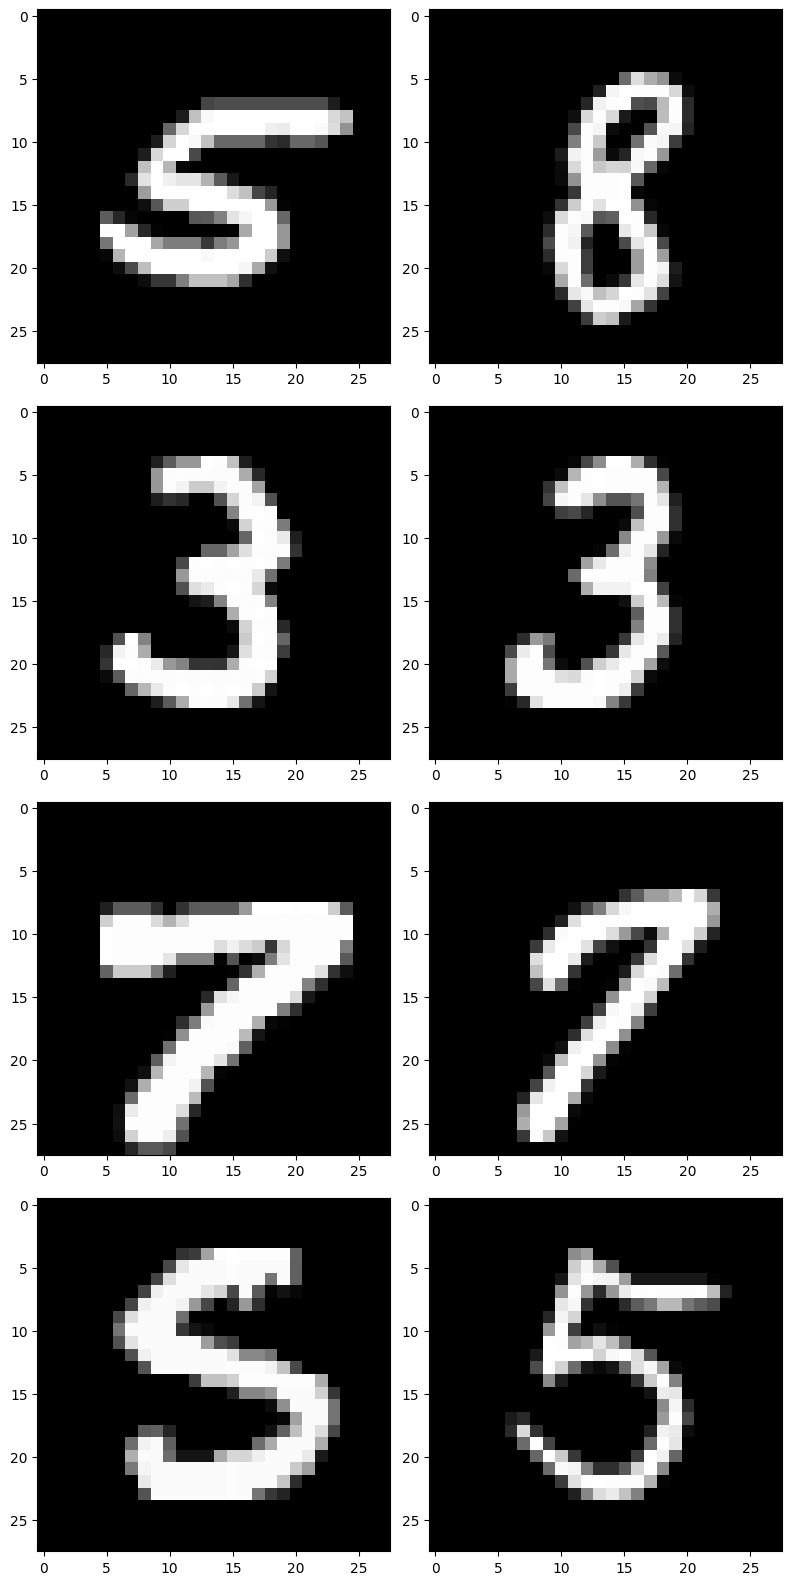

In [3]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt


class SiameseMNIST(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.length = len(self.dataset)
        self.pair_index = []
        
        labels = [label for _, label in self.dataset]
        positive_count = 0
        negative_count = 0
        random_index = np.arange(self.length)
        
        while positive_count + negative_count < self.length:
            np.random.shuffle(random_index)
            for i in np.arange(self.length):
                if labels[i] == labels[random_index[i]]:
                    if positive_count < self.length / 2:
                        self.pair_index.append([i, random_index[i], 1])
                        positive_count += 1
                    else:
                        continue
                else:
                    if negative_count < self.length / 2:
                        self.pair_index.append([i, random_index[i], 0])
                        negative_count += 1
                    else:
                        continue
                    
    def __len__(self):
        return self.length
    
    def __getitem__(self, index):
        return \
            self.dataset[self.pair_index[index][0]][0],\
            self.dataset[self.pair_index[index][1]][0],\
            torch.tensor(self.pair_index[index][2])
    
batch_size = 64
train_dataset = SiameseMNIST(train_dataset_original)
train_loader = DataLoader(
    train_dataset,                                                    # データセット
    batch_size=batch_size,                                            # バッチサイズ
    shuffle=True                                                      # データセットからランダムに取り出す
)
# ペア画像の確認（画像表示）
X1, X2, y = next(iter(train_loader))                             # １バッチ分だけデータを取り出す
print(X1[0].shape)
fig = plt.figure(tight_layout=True, figsize=(8, 16))
rows = 4                                                              # 表示行数，バッチサイズよりも小さな値で 
for i in range(rows):
    print(f"y[{i}]={y[i]}")
    ax = fig.add_subplot(rows, 2, i*2+1)
    ax.imshow(X1[i][0].numpy(), cmap='gray')                          # X1[i].shape = (1, 28, 28)，X1[i][0].shape = (28, 28)
    ax = fig.add_subplot(rows, 2, i*2+2)
    ax.imshow(X2[i][0].numpy(), cmap='gray') 

In [4]:
import torch.nn as nn

# Siamse Networkモデルクラス
class SiameseMnistModel(nn.Module):
    
    def __init__(self):
        super(SiameseMnistModel, self).__init__()
        self.flatten = nn.Flatten()

        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 32)
        )
    
    def forward_once(self, x):
        x = self.flatten(x)
        z = self.encoder(x)
        return z
  
    def forward(self, x1, x2):
        z1 = self.forward_once(x1)
        z2 = self.forward_once(x2)
        return z1, z2

In [5]:
# 損失関数
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, z1, z2, y):
        difference = z1 - z2
        distance_squared = torch.sum(torch.pow(difference, 2), 1)
        distance = torch.sqrt(distance_squared)       #平均：0.813，最大：1.663，最小：0.023，中央値：0.492
        negative_distance = self.margin - distance
        negative_distance = torch.clamp(negative_distance, min=0.0)
        loss = (y * distance_squared + (1 - y) * torch.pow(negative_distance, 2)) / 2.0
        loss = torch.sum(loss) / z1.size()[0]
        return loss

In [6]:
import torch.optim as optim
from torchsummary import summary

# モデルのインスタンス化
model = SiameseMnistModel().to(device)                # GPUを使用するには「.to(device)」が必要
print(model.parameters)
summary(model, input_size=[(1, 28*28), (1, 28*28)])   # 入力が２つあるので（ペア画像だから）input_sizeはリストで複数指定する

# 最適化関数の定義
optimizer = optim.SGD(model.parameters(), lr=0.05)    # パラメータ探索アルゴリズム=確率的勾配降下法(SGD), 学習率lr=0.05

# 損失関数のインスタンス化
criterion = ContrastiveLoss()                         # 引数として「margin=○○」が指定できる。デフォルト値は「margin=1.0」

<bound method Module.parameters of SiameseMnistModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=32, bias=True)
  )
)>
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,480
              ReLU-3                  [-1, 128]               0
            Linear-4                  [-1, 128]          16,512
              ReLU-5                  [-1, 128]               0
            Linear-6                   [-1, 32]           4,128
           Flatten-7                  [-1, 784]               0
            Linear-8                  [-1, 128]         100,480
          

epoch=0
nan/normal: 9/929
epoch=1
nan/normal: 9/929
epoch=2
nan/normal: 9/929
epoch=3
nan/normal: 8/930
epoch=4
nan/normal: 9/929
epoch=5
nan/normal: 9/929
epoch=6
nan/normal: 9/929
epoch=7
nan/normal: 9/929
epoch=8
nan/normal: 9/929
epoch=9
nan/normal: 9/929


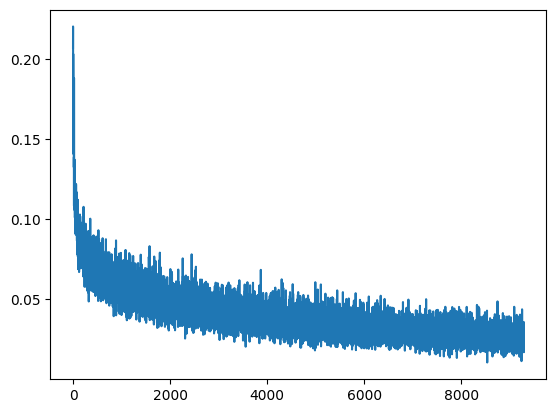

In [7]:
import copy
import matplotlib.pyplot as plt

# モデル学習
repeat = 10                                                       # 学習回数
losses = []                                                       # 表示用損失値配列

model.train()                                                     # 学習モード
for epoch in range(repeat): 
  print(f"epoch={epoch}")
  nan_count = 0
  normal_count = 0

  for X1, X2, y in train_loader:                                  # 学習用DataLoader
    # モデルによる特徴ベクトル算出
    output1, output2 = model(X1.to(device), X2.to(device))

    # 損失関数の計算
    loss = criterion(output1, output2, y.to(device))

    # nan対策（lossにnanが含まれていれば１回前のモデルに戻す）
    if torch.isnan(loss):
      model = prev_model
      optimizer = optim.SGD(model.parameters(), lr=0.05)
      optimizer.load_state_dict(prev_optimizer.state_dict())
      nan_count += 1
      continue
    else:
      prev_model = copy.deepcopy(model)
      prev_optimizer = copy.deepcopy(optimizer)
      normal_count += 1

    # 表示用lossデータの記録
    losses.append(loss.item())

    # 勾配を初期化
    optimizer.zero_grad()
    
    # 損失関数の値から勾配を求め誤差逆伝播による学習実行
    loss.backward()
    
    # 学習結果に基づきパラメータを更新
    optimizer.step()

  print(f"nan/normal: {nan_count}/{normal_count}")
plt.plot(losses)                                                  # loss値の推移を表示

In [8]:
# モデル評価
model.eval()                                                      # 評価モード
with torch.no_grad():
    z_test = []
    y_test = []
    for X, y in test_loader:                                      # テスト用DataLoader
        z_test.append(model.forward_once(X.to(device)))           # テストデータをモデルに通して出力ベクトルを得る
        y_test.append(y)
    z_test = torch.cat(z_test, dim=0)                             # 多次元torch.tensor要素のリストをtorch.tensor化
    y_test = torch.tensor(y_test)       

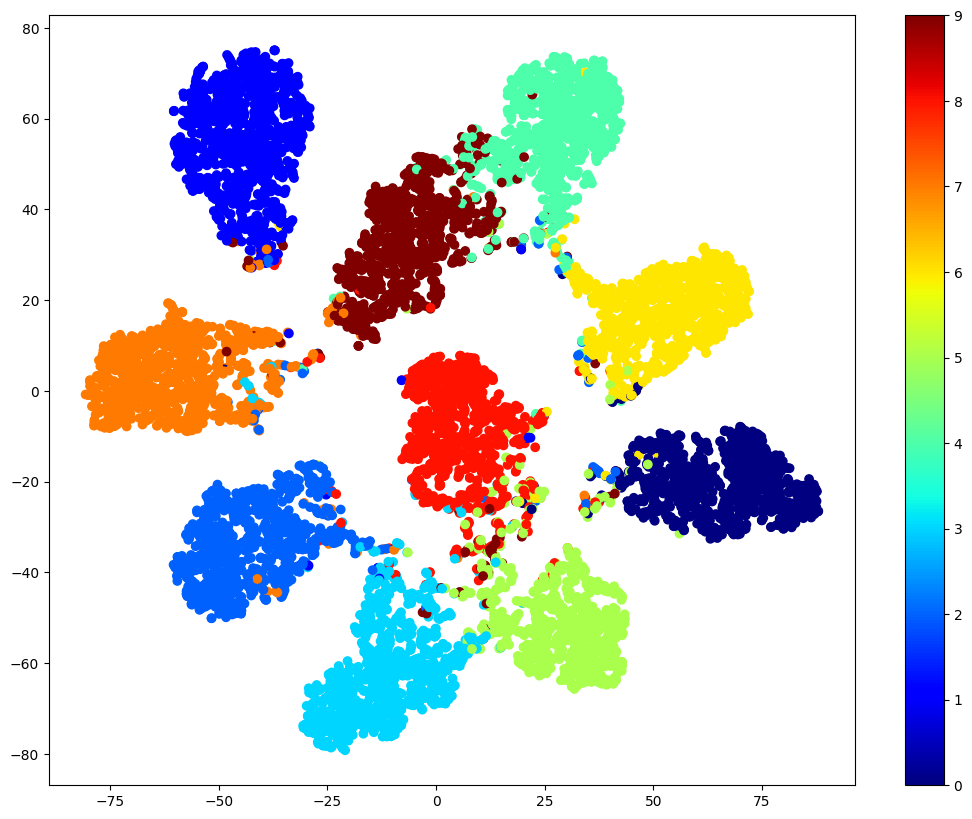

In [9]:
from sklearn.manifold import TSNE

def plot_tsne(x, y, colormap=plt.cm.Paired):
    plt.figure(figsize=(13, 10))
    plt.clf()
    tsne = TSNE()
    x_embedded = tsne.fit_transform(x)
    plt.scatter(x_embedded[:, 0], x_embedded[:, 1], c=y, cmap='jet')
    plt.colorbar()
    plt.show()

# t-SNEによるベクトル分布表示
z_test_np = z_test.to('cpu').detach().numpy().copy()                    # t-SNEはdeviceとしてCPUのみに対応（GPUはダメ）
y_test_np = y_test.to('cpu').detach().numpy().copy()
plot_tsne(z_test_np, y_test_np)


In [10]:
from sklearn.cluster import KMeans

# k-meansによるクラスタリング
kmeans = KMeans(n_clusters=10)                                             # クラスタ数は10で指定します
kmeans.fit(z_test_np)

# ラベルの付け替え
counts = {}
for cluster_label, test_label in zip(kmeans.labels_, y_test_np):           # cluster_label：クラスタラベル，test_label：テスト画像ラベル
  if cluster_label not in counts.keys():
    counts[cluster_label] = [0] * 10                                       # 「<cluster_label>:[0,0,0,0,0,0,0,0,0,0]」をcountsに追加（初期化）
  counts[cluster_label][test_label] += 1
print(counts)
mapping = {}
for cluster_label in range(10):
  mapping[cluster_label] = counts[cluster_label].index(max(counts[cluster_label]))

# 正解率の計算
mapped_cluster_label = np.array([mapping[cluster_label] for cluster_label in kmeans.labels_])
accuracy = sum(mapped_cluster_label == y_test_np) / len(y_test_np)* 100
print(accuracy)


{5: [2, 10, 9, 15, 2, 27, 5, 1, 908, 4], 7: [967, 0, 10, 0, 0, 7, 9, 1, 0, 3], 8: [0, 1, 3, 0, 33, 6, 0, 38, 7, 933], 0: [1, 4, 985, 11, 2, 1, 1, 19, 7, 0], 4: [0, 1116, 1, 0, 0, 1, 3, 11, 2, 8], 9: [0, 2, 3, 958, 0, 10, 0, 5, 9, 5], 6: [5, 1, 9, 0, 16, 5, 932, 0, 6, 2], 2: [0, 0, 3, 0, 929, 1, 7, 0, 3, 29], 3: [4, 1, 1, 15, 0, 832, 1, 1, 31, 20], 1: [1, 0, 8, 11, 0, 2, 0, 952, 1, 5]}
95.12


: 